# 29회 ADP 복원 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tools.eval_measures import rmse

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.rcParams['font.family']='Malgun Gothic'

import warnings
warnings.filterwarnings('ignore')

# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15094266/fileData.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv
- 데이터 설명 : 대구도시공사_빅데이터_영구임대아파트 입주자 퇴거여부 데이터, 고유번호를 가진 계약자와 특정 아파트에 대해 매년 퇴거여부를 기록한 데이터

In [2]:
#encoding = ['utf-8','cp949','utf-8-sig','euc-kr','latin']
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv',encoding= 'cp949')
df.head()

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,...,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2008,47100,3646000,46,33,남,미혼,3,미퇴거
1,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2009,56500,4375000,46,34,남,미혼,3,미퇴거
2,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2010,56500,4375000,46,35,남,미혼,3,미퇴거
3,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2011,69900,5408000,46,36,남,미혼,3,미퇴거
4,1,유효,10,222,강남아파트,5,7.0,14520,1,12,...,NaN,2012,69900,5408000,46,37,남,미혼,3,미퇴거


## 1-1  계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [3]:
print(df.shape)
df = df.sort_values(by = ['계약자고유번호', '거주연도'],ascending=[True, False]).drop_duplicates(['계약자고유번호'], keep = 'first')
print(df.shape)

(86904, 23)
(10348, 23)


#### [답안]
- 계약자고유번호 오름차순, 거주연도 내림차순으로 정렬 후 계약자고유번호를 기준으로 첫번째 행만 남기고 중복을 제거하였다. 그 결과 86,904건에서 10,348건으로 줄어들었다.

## 1-2 결측치 처리

In [4]:
print(df.isna().sum()[df.isna().sum() >0])


print('\n계약구분 결측치 처리')
print(df.loc[:,['계약구분','퇴거여부']].value_counts(dropna = False))
df.loc[(df.퇴거여부 == '퇴거')&(df.계약구분.isna()), '계약구분'] = '해지'
df.loc[(df.퇴거여부 == '미퇴거')&(df.계약구분.isna()), '계약구분'] = '유효'


print('\n아파트 평점 결측치 처리')
# 아파트 평점은 아파트ID별로 같을 것이라 생각하고 아파트ID별 최빈값으로 대체
na평점_아파트id = list(df.loc[df['아파트 평점'].isna(),'아파트 ID'].unique())
for i in na평점_아파트id:
    mode = df.loc[df['아파트 ID']==i,'아파트 평점'].mode()
    df.loc[(df['아파트 ID']==i)&(df['아파트 평점'].isna()),'아파트 평점'] = int(mode)
    

print('\n퇴거연도 결측치 처리')
print(df.loc[df.퇴거연도.isna(),'퇴거여부'].value_counts(dropna = False))
df.loc[df.퇴거연도.isna(),'퇴거연도'] = 9999

계약구분        61
아파트 평점     140
퇴거연도      6256
dtype: int64

계약구분 결측치 처리
계약구분  퇴거여부
유효    미퇴거     6217
해지    퇴거      4070
NaN   미퇴거       39
      퇴거        22
Name: count, dtype: int64

아파트 평점 결측치 처리

퇴거연도 결측치 처리
퇴거여부
미퇴거    6256
Name: count, dtype: int64


#### [답안]
- 결측이 있는 컬럼은 계약구분, 아파트 평점, 퇴거연도 3개이다.
- 계약구분의 경우 퇴거여부와 관련이 있기 때문에 퇴거한 건의 계약구분은 해지, 미퇴거한 건의 계약구분은 유효로 처리했다.
- 아파트 평점은 아파트ID별로 같을 것이라 생각하고 아파트ID별 최빈값으로 대체한다.
- 퇴거연도는 미퇴거인 건에만 존재하는데 입주중이기때문에 데이터가 존재하지 않으므로 NA가 맞다. NA를 9999로 표시했다.

## 1-3 이상치 처리

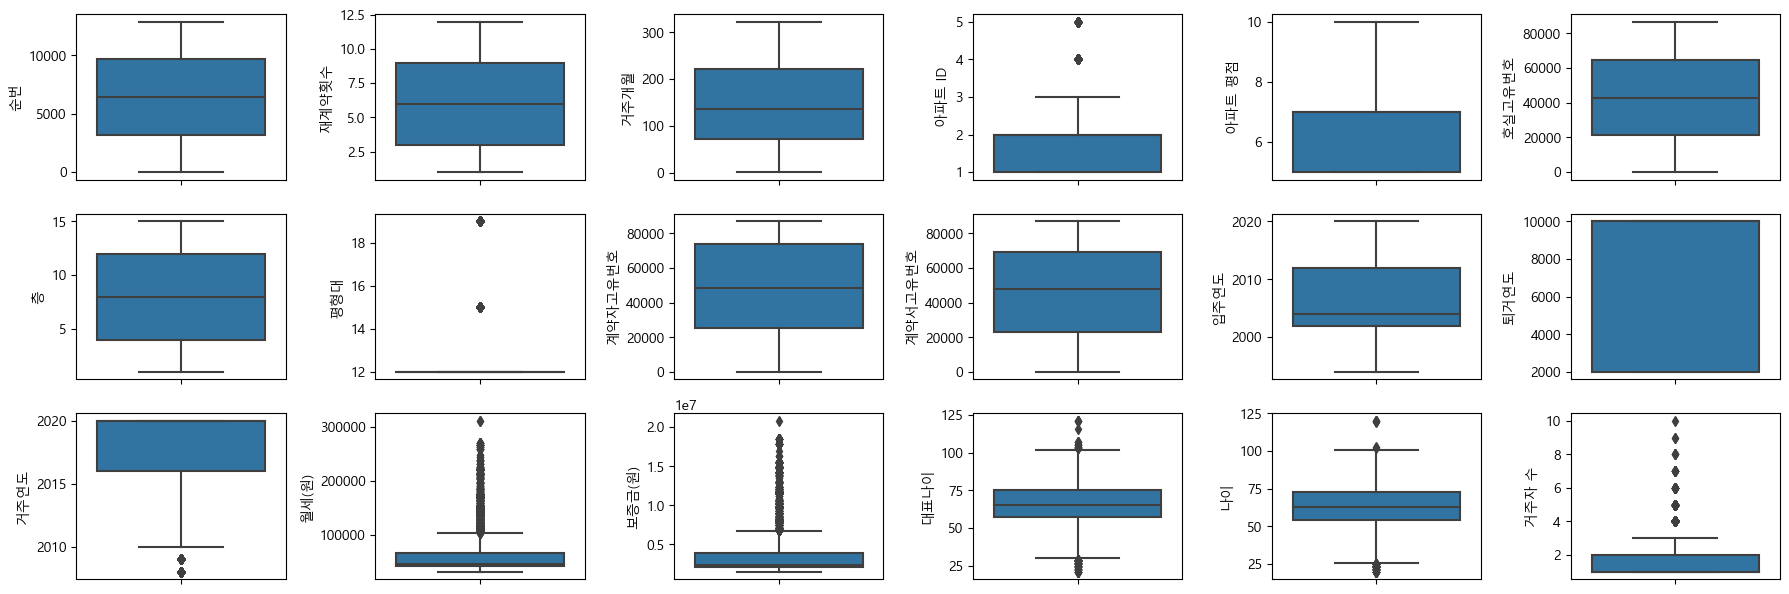

Index(['순번', '재계약횟수', '거주개월', '아파트 ID', '아파트 평점', '호실고유번호', '층', '평형대',
       '계약자고유번호', '계약서고유번호', '입주연도', '퇴거연도', '거주연도', '월세(원)', '보증금(원)', '대표나이',
       '나이', '거주자 수'],
      dtype='object')


In [5]:
# 연속형 컬럼만 추출
num_col = df.select_dtypes(exclude = ['object'])

# boxplot 시각화
n_row = 3
n_col = 6
fig, axs = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*2))

for r in range(0, n_row):
    for c in range(0, n_col):
        i = r*n_col +c
        if i < len(num_col.columns):
            sns.boxplot(y = list(num_col.columns)[i], data = df, ax = axs[r][c])
plt.tight_layout()
plt.show()

print(num_col.columns)

#### [답안]
- boxplot을 보았을때 데이터가 크게 벗어난 점이 보이지 않아 이상치처리는 하지 않는다. 

## 2-1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.

In [6]:
med = df.재계약횟수.median()
df['재계약이분변수'] = '높음'
df.loc[df['재계약횟수'] < med, '재계약이분변수'] = '낮음'
print(df.재계약이분변수.value_counts())

재계약이분변수
높음    5388
낮음    4960
Name: count, dtype: int64


#### [답안]
- 재계약횟수 이분변수를 만들어 건수를 보니 높음이 5388건, 낮음이 4960이다.

## 2-2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.

In [7]:
df.shape

(10348, 24)

#### [답안]
- 차원축소는 고차원 데이터의 모델 복잡성을 줄이고 과적합 문제를 줄이며 예측 성능을 향상시키기 위해 사용된다. 그러나 차원축소를 하면 정보를 손실할 수 있다. 그리고 데이터가 이미 낮은 차원에 있는 경우 차원축소가 불필요하다. 그리고 때로는 차원축소가 모델 성능을 저하시킬 수 있다. 해당 데이터는 24개의 컬럼과 10348개의 행을 가진 데이터로 차원축소가 필요할 정도의 고차원 데이터가 아니다. 따라서 차원축소 없이 진행한다.

## 3-1 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.

<Axes: xlabel='보증금(원)', ylabel='거주개월'>

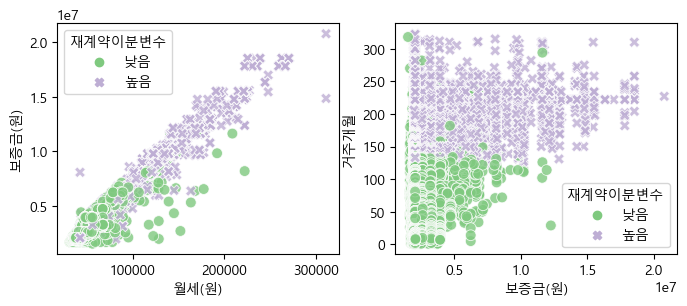

In [8]:
fig, axs = plt.subplots(1,2, figsize = (2*4, 1*3))
sns.scatterplot(x = '월세(원)', y = '보증금(원)', data = df, hue = '재계약이분변수', style = '재계약이분변수', s = 60,
                ax = axs[0], palette = 'Accent', alpha=0.8)

sns.scatterplot(x = '보증금(원)', y = '거주개월', data = df, hue = '재계약이분변수', style = '재계약이분변수', s = 60, 
                ax = axs[1], palette = 'Accent', alpha=0.8)

#### [답안]
- 재계약이분변수 '낮음'의 경우 보증금과 월세가 적은 경우가 많고 거주개월이 비교적 짧다.
- 재계약이분변수 '높음'의 경우 보증금과 월세가 높은 경우에 많고 거주개월도 길다. 

## 3-2. 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 

In [10]:
def preprocessing(x_data, y_data, scale_col, enc_col):
    # 데이터 스케일링
    from sklearn.preprocessing import StandardScaler
    x_data_scale = StandardScaler().fit_transform(x_data[scale_col])
    
    # 원핫인코딩
    from sklearn.preprocessing import OneHotEncoder
    x_data_enc = OneHotEncoder(sparse = False).fit_transform(x_data[enc_col])# .values.reshape(-1, 1) 변수가 하나일때
    print(x_data_scale.shape)
    print(x_data_enc.shape)
    # 합치기
    x_data = np.concatenate([x_data_scale, x_data_enc], axis = 1)

    y_data_r = y_data.values.ravel()

    # 데이터 분할
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_r, test_size = 0.2, random_state = 123)

    return x_train, x_test, y_train, y_test

## 회귀 분석

# '재계약이분변수','재계약횟수' 제외!!! 순번, 아파트 이름, 아파트 ID, 고유번호 등 변수 제외
scale_col = ['거주개월', '아파트 평점', '층', '평형대', '입주연도', '퇴거연도', '거주연도', '월세(원)', '보증금(원)',
            '대표나이', '나이', '거주자 수']
enc_col = ['계약구분', '성별', '결혼여부', '퇴거여부']

feature_names = scale_col+enc_col
# 데이터 분할
x_train, x_test, y_train, y_test = preprocessing(df[feature_names], df['재계약횟수'], scale_col, enc_col)

# 회귀모델 생성
rf = RandomForestRegressor(n_estimators = 500, max_depth = 3)
model_rf = rf.fit(x_train, y_train)

xgb = XGBRegressor(max_depth = 5, n_estimators = 500)
model_xgb = xgb.fit(x_train, y_train)

# 테스트 예측
pred_rf = model_rf.predict(x_test)
pred_xgb = model_xgb.predict(x_test)

# 성능평가
rmse_rf = rmse(y_test, pred_rf)
rmse_xgb = rmse(y_test, pred_xgb)

print('RMSE 평가 결과 1. rf : {:.10f}, 2. xgboost : {:.10f}'.format(rmse_rf, rmse_xgb))

## 분류모델
df['재계약이분변수'] = [1 if i =='높음' else 0 for i in df['재계약이분변수'] ]

# 데이터 분할
x_train, x_test, y_train, y_test = preprocessing(df[feature_names], df['재계약이분변수'], scale_col, enc_col)

# 분류모델 생성
xgbc = XGBClassifier(n_estimators = 500)
model_xgbc = xgbc.fit(x_train, y_train)

dtc = DecisionTreeClassifier()
model_dtc = dtc.fit(x_train, y_train)

# 테스트 예측
pred_xgbc = model_xgbc.predict(x_test)
pred_dtc = model_dtc.predict(x_test)

# 성능평가
rmse_xgbc = accuracy_score(pred_xgbc, y_test)
rmse_dtc = accuracy_score(pred_dtc, y_test)

print('accuracy_score 평가 결과 1.  xgboost : {:.10f}, 2.  decisiontree : {:.10f}'.format(rmse_xgbc, rmse_dtc))


(10348, 12)
(10348, 8)
RMSE 평가 결과 1. rf : 0.7956805041, 2. xgboost : 0.6110769552
(10348, 12)
(10348, 8)
accuracy_score 평가 결과 1.  xgboost : 0.9801932367, 2.  decisiontree : 0.9623188406


#### [답안]
- 모델을 만들기 전 연속형 변수의 경우 스케일링을 처리하고 범주형 변수의 경우 인코딩을 수행한 후, train, test 데이터로 8:2로 분할하였다.
- 첫번째 재계약횟수를 종속변수로 한 회귀모델에서는 랜덤포레스트와 XGBoost 모델을 사용하였다. test데이터를 예측하여 RMSE를 살펴본 결과 랜덤포레스트 0.795, XGBoost 0.611으로 XGBoost가 예측력이 더 좋은 결과를 얻었다.
- 두번째 재계약이분변수를 종속변수로 한 분류모델에서는 XGBoost와 의사결정나무 모델을 사용하였다. test데이터를 예측하여 실제값과 accuracy score로 비교한 결과 XGBoost 0.98, 의사결정나무는 0.9623의 결과로 XGBoost가 예측력이 더 좋은 결과를 얻었다.

## 3-3 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명하시오

,feature_nm,xgb_importances,xgbc_importances
0,거주개월,0.823490,0.723928
1,아파트 평점,0.016789,0.047366
2,층,0.004226,0.009839
3,평형대,0.011671,0.015220
4,입주연도,0.016228,0.037748
5,퇴거연도,0.051318,0.046776
6,거주연도,0.000000,0.000000
7,월세(원),0.012819,0.022393
8,보증금(원),0.029022,0.028789
9,대표나이,0.004697,0.010694


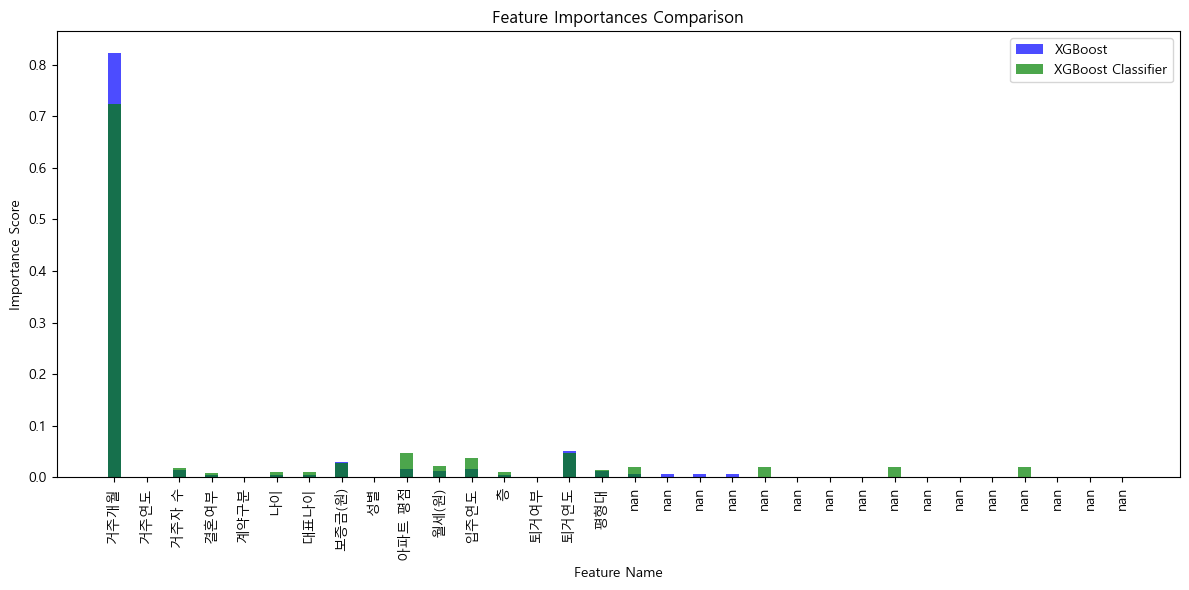

In [26]:
imp = model_xgb.feature_importances_
column_nm = pd.DataFrame(feature_names)
df_imp1 = pd.concat([column_nm, pd.DataFrame(imp)], axis = 1)
df_imp1.columns = ['feature_nm', 'xgb_importances']

imp = model_xgbc.feature_importances_
column_nm = pd.DataFrame(feature_names)
df_imp2 = pd.concat([column_nm, pd.DataFrame(imp)], axis = 1)
df_imp2.columns = ['feature_nm', 'xgbc_importances']

df_imp = pd.merge(df_imp1, df_imp2, on = 'feature_nm')
display(df_imp)


# 중요도 점수를 feature_nm으로 정렬
df_imp = df_imp.sort_values(by='feature_nm')


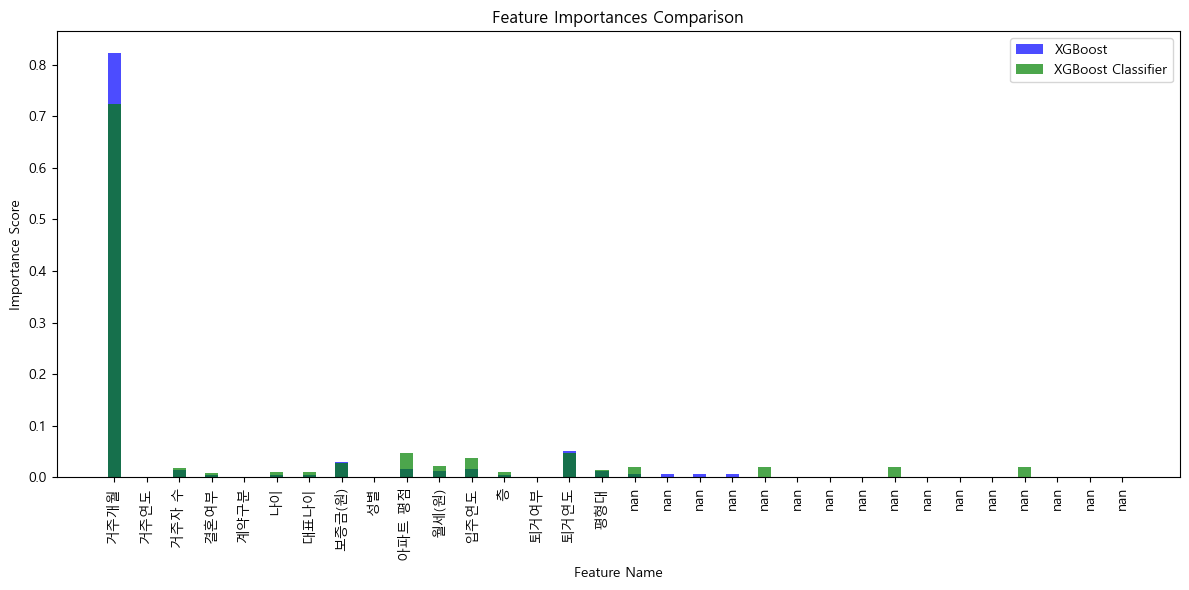

In [28]:

# 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
x = range(len(df_imp))  # x 축은 숫자로 표시
plt.bar(x, df_imp['xgb_importances'], label='XGBoost', alpha=0.7, color='b', width=0.4)
plt.bar(x, df_imp['xgbc_importances'], label='XGBoost Classifier', alpha=0.7, color='g', width=0.4)
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Feature Importances Comparison')
plt.xticks(x, df_imp['feature_nm'], rotation=90)  # x 축 레이블을 feature_nm 값으로 설정
plt.legend()
plt.tight_layout()

plt.show()

#### [답안]
- 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 변수중요도를 통해 살펴보았다. 두개의 모델 모두 거주개월이 모델에 영향을 많이 미치는 변수였다.

## 3-4 해당 데이터 분석결과로 얻을 수 있는 점 제시

#### [답안] 1시간
- 해당 데이터의 분석결과로 알 수 있는 점은 재계약를 많이 하는 거주자의 특성을 알 수 있었다. 재계약 횟수에 영향을 주는 변수들은 거주개월, 아파트 평점, 월세 등의 변수이다. 이를 통해 재계약 여부를 판단하는 모델을 만들 수 있다. 모델을 만들때 데이터를 더 살펴보고 전처리 과정이 필요하다.

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018 데이터를 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv
- 데이터 설명 : 

A 야구구단의 시합 결과중 일부를 나타낸다.    
각 행은 하나의 경기를 의미(game_id)하며 9회차(= 9이닝) 동안 1번타자, 2번타자의 출루 정보를 의미한다.     
각 컬럼에 대한 설명은 아래 이미지와 같으며, value값의 index는 이미지의 '수치 의미' 열을 통해 확인 할 수 있다.


<img src="https://github.com/Datamanim/datarepo/blob/main/adp/29/p1_img.png?raw=true" width="500" height="600">

## 4-1 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)     

조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)     
조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.    
조건3 : 학습에 적절하지 않은 데이터는 제외한다.    

제가 이해하고 의도한 29회 4-1번 문제에 대한 가이드 입니다.
(4-1) 전처리 가이드
1. 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
2. 정수형 값이 아닌 데이터 행를 제거
3. 홈런 (4)값을 가지는 행을 제거
4. 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
5. 둘째 타자 출루 결과를 one-hot encoding

In [29]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv',encoding= 'cp949')
df.head()

,game_id,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,...,a9_2,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,201900016,5,5,5,5,5,5,5,5,5,...,5,0,0,0,0,0,0,0,4,2
1,201900023,6,4,5,5,2,5,1,1,6,...,7,3,0,0,1,0,1,3,1,0
2,201900103,5,6,5,5,1,9,5,4,6,...,6,0,0,1,1,4,1,2,0,1
3,201900112,5,7,6,1,5,5,1,5,1,...,5,0,3,0,0,0,0,1,0,0
4,201900131,5,1,2,5,2,5,7,2,6,...,6,0,2,4,1,2,2,0,1,0


## 4-2 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 하라

## 4-3 SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라

## 4-4 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라

## 4-5 4-3 구성 데이터에 XGB 적용하고 결과를 분석하라

# 통계 (40점)

## 5. 제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을 구하시오. (소수점 다섯 째 자리에서 반올림)

In [2]:
from scipy.stats import binom
print('25개의 제품을 뽑았을 때 3개가 불량일 확률은 {:5f}이다'.
      format(binom.pmf(3, 25, 0.03)))

25개의 제품을 뽑았을 때 3개가 불량일 확률은 0.031774이다


## 6. C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정하여라.

In [15]:
p1 = 0.6
p2 = 0.4
n1 = 1000
n2 = 500

conf_a = 0.05
test_a = 0.05

d0 = 0
d - p1-p2
pe = (n1*p1+ n2*p2) / (n1+n2) # pooled esimate
SE2 = np.sqrt( pe*(1-pe)*(1/n1+1/n2)) # 합동 분산을 사용한 SE
zstat = d / SE2 # 검정통계량

conf_z = norm.ppf(1-conf_a/2)
ME2 = conf_z * SE2 # 오차의 한계

sp = (1-norm.cdf(np.abs(zstat)))*2
cv = norm.ppf(1-test_a/2)
print('임계값: {}, 검정통계량: {}'.format(cv, zstat))
print('유의수준: {:.3f}, 유의확률: {:.5f}'.format(test_a, sp))
print('신뢰구간: {:.3f}~{:.3f}, 검정하고자 하는 값: {:.3f}'.
     format(d-ME2, d+ME2, d0))

임계값: 1.959963984540054, 검정통계량: 7.319250547113997
유의수준: 0.050, 유의확률: 0.00000
신뢰구간: 0.146~0.254, 검정하고자 하는 값: 0.000


#### [답안]
- 귀무가설 : 모비율의 차는 0이다.
- 대립가설 : 모비율의 차는 0이 아니다.
- 유의수준이 유의확률(0.05)보다 작으므로 귀무가설을 기각한다. 모비율의 차는 0이 아니다. 두 회사의 양품률에는 차이가 있다.

## 7. 아래 데이터는 a,b,c,d 네 차종 각각 5회 실험 시 범퍼 파손 정도 이다. (단, 각 모집단은 정규분포를 따르며 모집단 간 등분산성을 가정한다.)

dataurl : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv

### 7-1. 각 차종 별 범퍼 파손의 정도에 차이가 유의한지 검정하라.

In [24]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')
stats.f_oneway(df.loc[df.name=='A','ratio'], df.loc[df.name=='B','ratio'],
               df.loc[df.name=='C','ratio'], df.loc[df.name=='D','ratio'])

F_onewayResult(statistic=24.97695307518529, pvalue=2.8174779556216382e-06)

#### [답변]
- 귀무가설 : 각 차종별 범퍼 파손의 정도에 차이가 없다.
- 연구가설 : 적어도 하나의 차종의 범퍼 파손의 정도에 차이가 있다.
- 통계량 24.977, 유의확률(pvalue) 2.817로 유의수준 0.05보다 크므로 귀무가설을 채택한다.

### 7-2 귀무가설을 채택한다면 그 의미를 해석하고, 귀무가설을 기각하였다면 사후분석을 시행하라.

#### [답변]
- 귀무가설을 채택하는데, 각 차종별 범퍼 파손의 정도에 차이가 없다는 것을 의미한다.

## 8. L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률을 구하시오. (소수점 둘째자리에서 반올림)

In [27]:
# P(L1|불량) = P(L1∩불량) / P(불량)

# P(L1) = 0.13
# P(L2) = 0.37
# P(L3) = 0.5

# P(불량|L1) = 0.011
# P(불량|L2) = 0.021
# P(불량|L3) = 0.033

# P(불량) = P(L1∩불량)      + P(L2∩불량)      + P(L3∩불량) 
#         = P(불량|L1)*P(L1) + P(불량|L2)*P(L2) + P(불량|L3)*P(L3)
L1_불량 = 0.011*0.13
불량 = 0.011*0.13 + 0.021*0.37 + 0.033*0.5

print('[답안]')
print('불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률은 {:.3f}입니다.'.
      format(L1_불량/불량))

[답안]
불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률은 0.056입니다.


created by datamanim [web-link](https://www.datamanim.com)

#### 끝. 10페이지